In [57]:
import backtrader as bt
import numpy as np
import pandas as pd
import yfinance as yf
from pyfolio.tears import create_full_tear_sheet
from scipy.optimize import minimize

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [58]:
class SharpeOptimize(bt.Strategy):
    _RISK_FREE = 0.05
    params = dict()

    def __init__(self):
        self.m_hist = []
        self.pf = np.array([1 / len(self.datas)] * len(self.datas))

    def next(self):
        buy = []
        self.m_hist.append([self.datas[i][0] for i in range(len(self.datas))])
        if len(self) > 24:
            self.optimize_shrp()
            for i, w in enumerate(self.pf):
                curr_stake = self.getposition(self.datas[i], self.broker).size
                new_stake = self.broker.get_value(self.datas) * w // self.datas[i][0]
                if new_stake > curr_stake:
                    buy.append([self.datas[i], new_stake - curr_stake])
                if new_stake < curr_stake or (w < 0.01 and curr_stake > 0):
                    if curr_stake - new_stake <= 0:
                        self.close(self.datas[i])
                    else:
                        self.sell(self.datas[i], size=curr_stake - new_stake)
            for b in buy:
                self.buy(b[0], b[1])

    def shrp(self, return_rates, w):
        R = np.matmul(return_rates.to_numpy(), w)
        return np.sqrt(12) * (R.mean() - self._RISK_FREE) / R.std()

    def optimize_shrp(self):
        return_rates = pd.DataFrame(self.m_hist).pct_change().dropna()
        w0 = self.pf.copy()
        bounds = [(0, 1) for _ in range(len(w0))]
        result = minimize(
            lambda w: -self.shrp(return_rates, w),
            w0,
            bounds=bounds,
            constraints={"type": "eq", "fun": lambda x: sum(x) - 1},
        )
        self.pf = np.array(result.x)


def gen_portfolio(tickers, start, interval):
    index = pd.Series()
    data = []
    for tkr in tickers:
        if interval == "1y":
            hist = yf.Ticker(tkr).history(start=start, interval="1mo").iloc[::12]
        else:
            hist = yf.Ticker(tkr).history(start=start, interval=interval)
        if not hist.Close.empty:
            hist = hist.dropna()
            if len(index) > 0 and hist.shape[0] < len(index):
                print(f"Skipping ticker {tkr} due to insufficient data")
            else:
                index = hist.index
                hist.name = tkr
                data.append(hist)
    return data


def init_cerebro(data: list[pd.DataFrame]) -> bt.Cerebro:
    cerebro = bt.Cerebro()
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
    cerebro.addanalyzer(bt.analyzers.Returns, _name='r')
    for row in data:
        cerebro.adddata(bt.feeds.PandasData(dataname=row))
    return cerebro

In [59]:
pf_sp_500 = gen_portfolio(
    pd.read_csv("../data/sp500_members.csv").Symbol, "2013-01-01", "1mo"
)

Skipping ticker ABBV due to insufficient data
Skipping ticker ABNB due to insufficient data
Skipping ticker ALLE due to insufficient data
Skipping ticker ANET due to insufficient data
Skipping ticker CZR due to insufficient data
Skipping ticker CARR due to insufficient data
Skipping ticker CTLT due to insufficient data
Skipping ticker CDW due to insufficient data
Skipping ticker CFG due to insufficient data
Skipping ticker CEG due to insufficient data
Skipping ticker CTVA due to insufficient data
Skipping ticker DAY due to insufficient data
Skipping ticker DOW due to insufficient data
Skipping ticker ETSY due to insufficient data
Skipping ticker FTV due to insufficient data
Skipping ticker FOXA due to insufficient data
Skipping ticker FOX due to insufficient data
Skipping ticker GEHC due to insufficient data
Skipping ticker HPE due to insufficient data
Skipping ticker HLT due to insufficient data
Skipping ticker HWM due to insufficient data
Skipping ticker IR due to insufficient data
S

In [60]:
cerebro = init_cerebro(pf_sp_500)
cerebro.broker.setcash(100000.0)
cerebro.addstrategy(SharpeOptimize)
results = cerebro.run()

Normalized return %: 1160.6067332674218


Start date,2013-01-01
End date,2024-03-01
Total months,6
,Backtest
Annual return,1160.607%
Cumulative returns,288.684%
Annual volatility,187.604%
Sharpe ratio,2.25
Calmar ratio,17.01
Stability,0.78
Max drawdown,-68.24%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,68.24,2022-07-01,2023-10-01,NaT,NaN
1,37.00,2015-05-01,2016-11-01,2017-06-01,545
2,28.02,2021-11-01,2022-01-01,2022-07-01,175
3,27.31,2020-02-01,2020-03-01,2020-05-01,65
4,20.41,2019-08-01,2019-10-01,2020-01-01,110


/home/adam/investing/backtest/pyfolio/plotting.py:1369: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(
/home/adam/investing/backtest/pyfolio/plotting.py:1397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,-4.27%,-4.27%,-4.27%
Recovery,0.00%,0.00%,0.00%
New Normal,1.17%,-27.66%,27.02%
Covid,1.79%,-28.59%,45.72%


Top 10 long positions of all time,max


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data460,0.00%


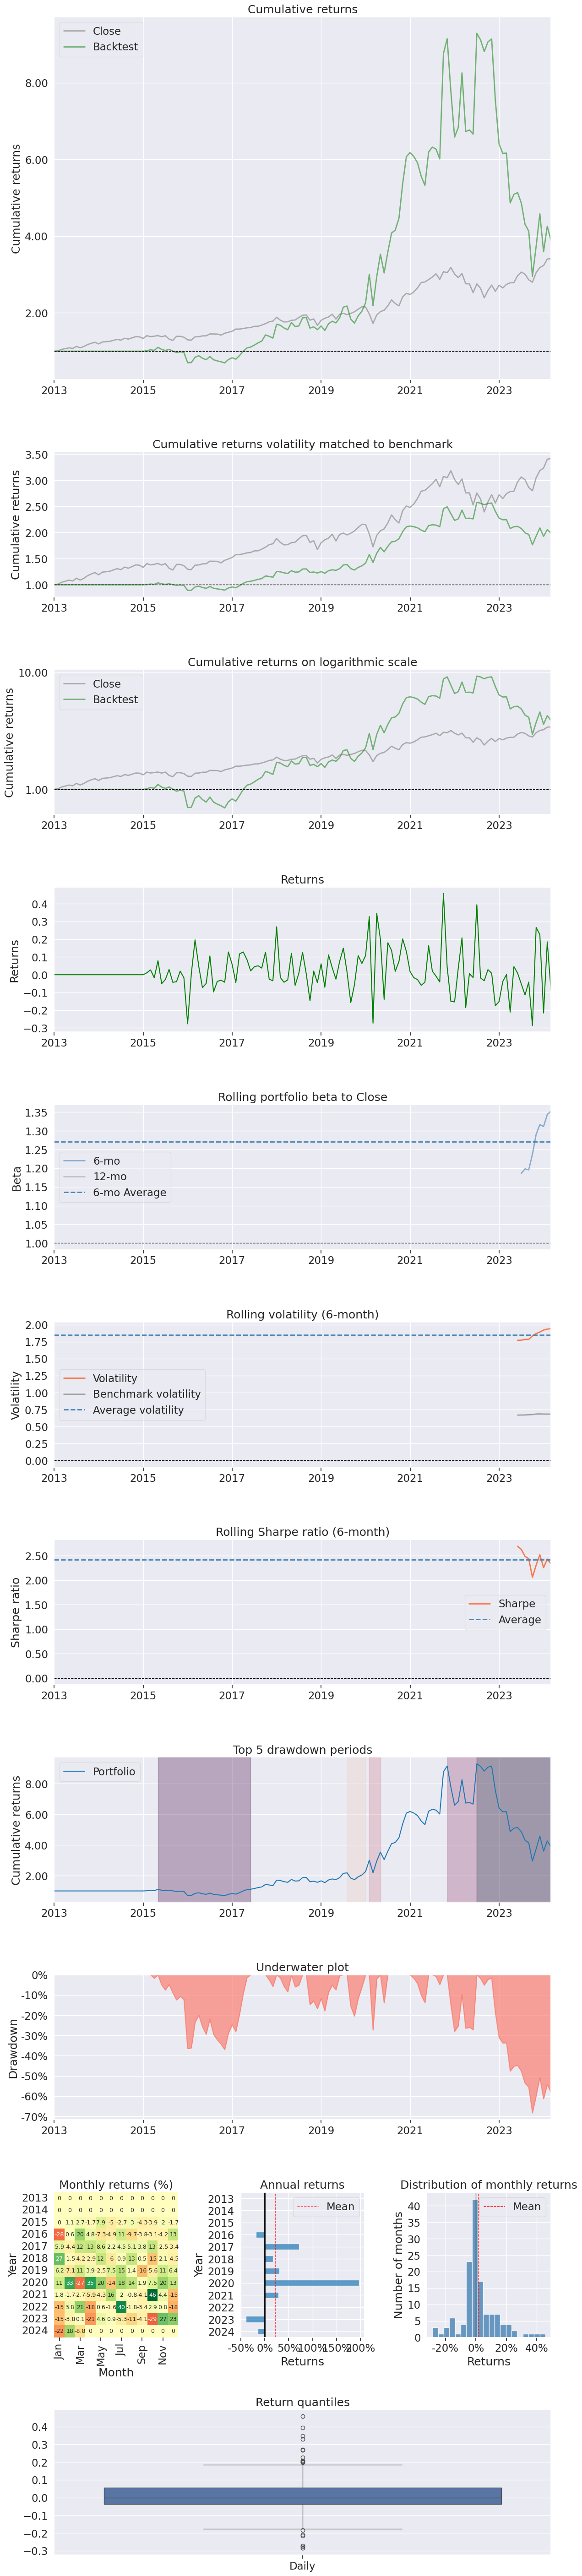

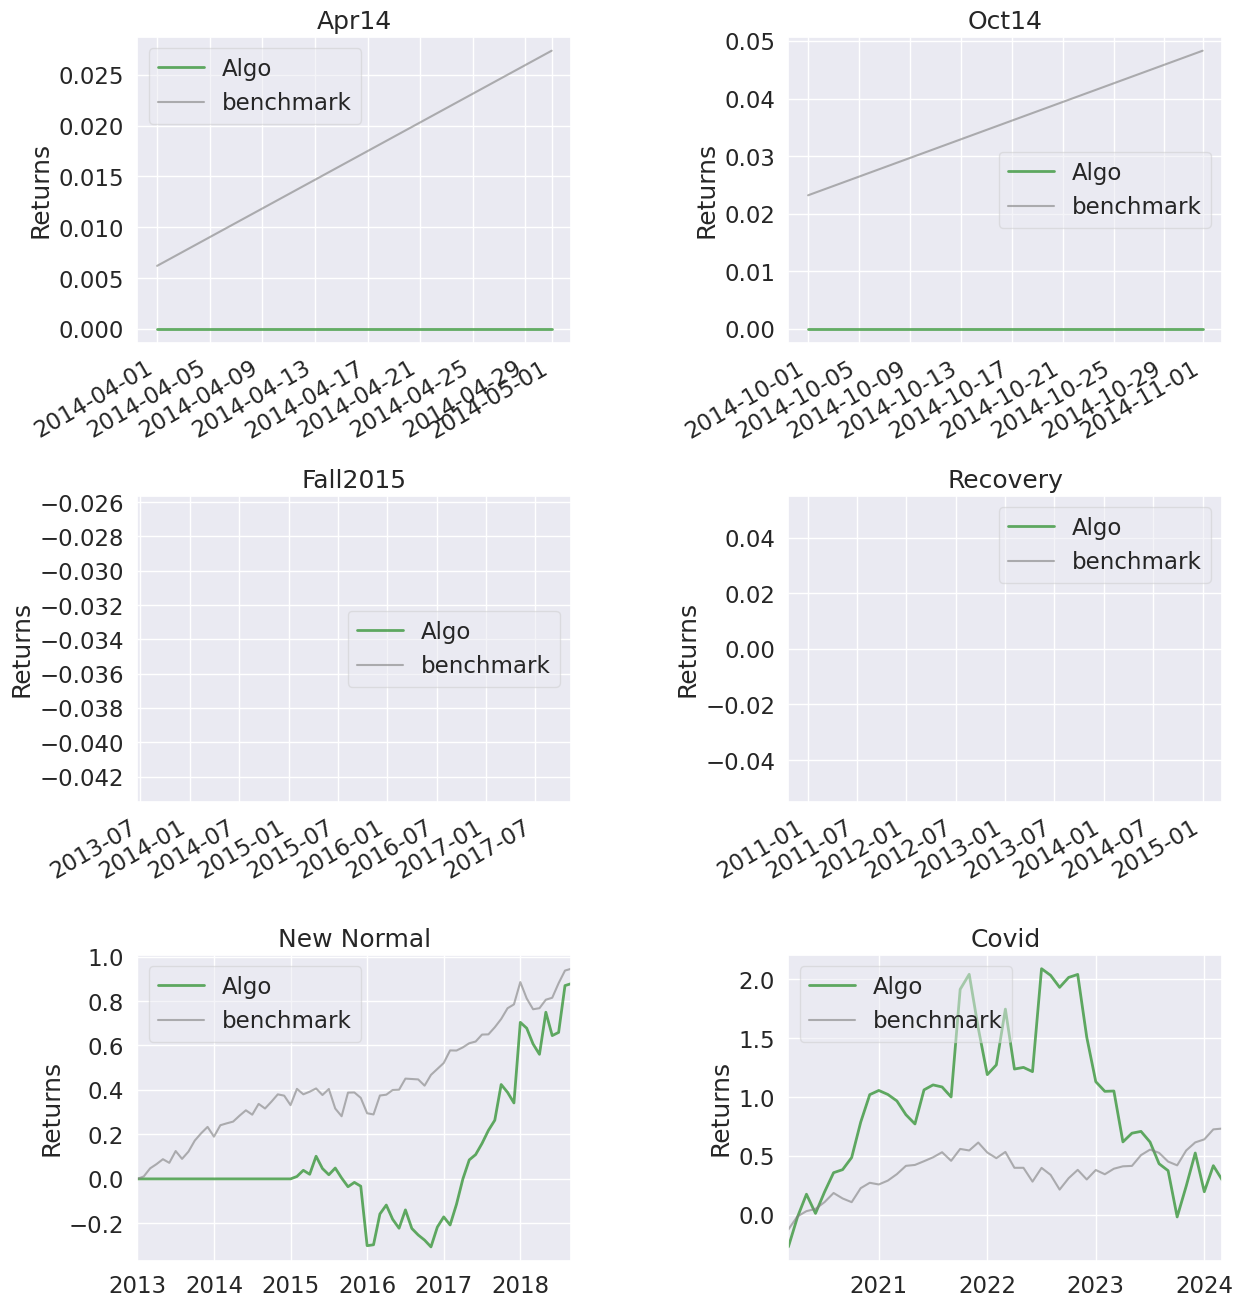

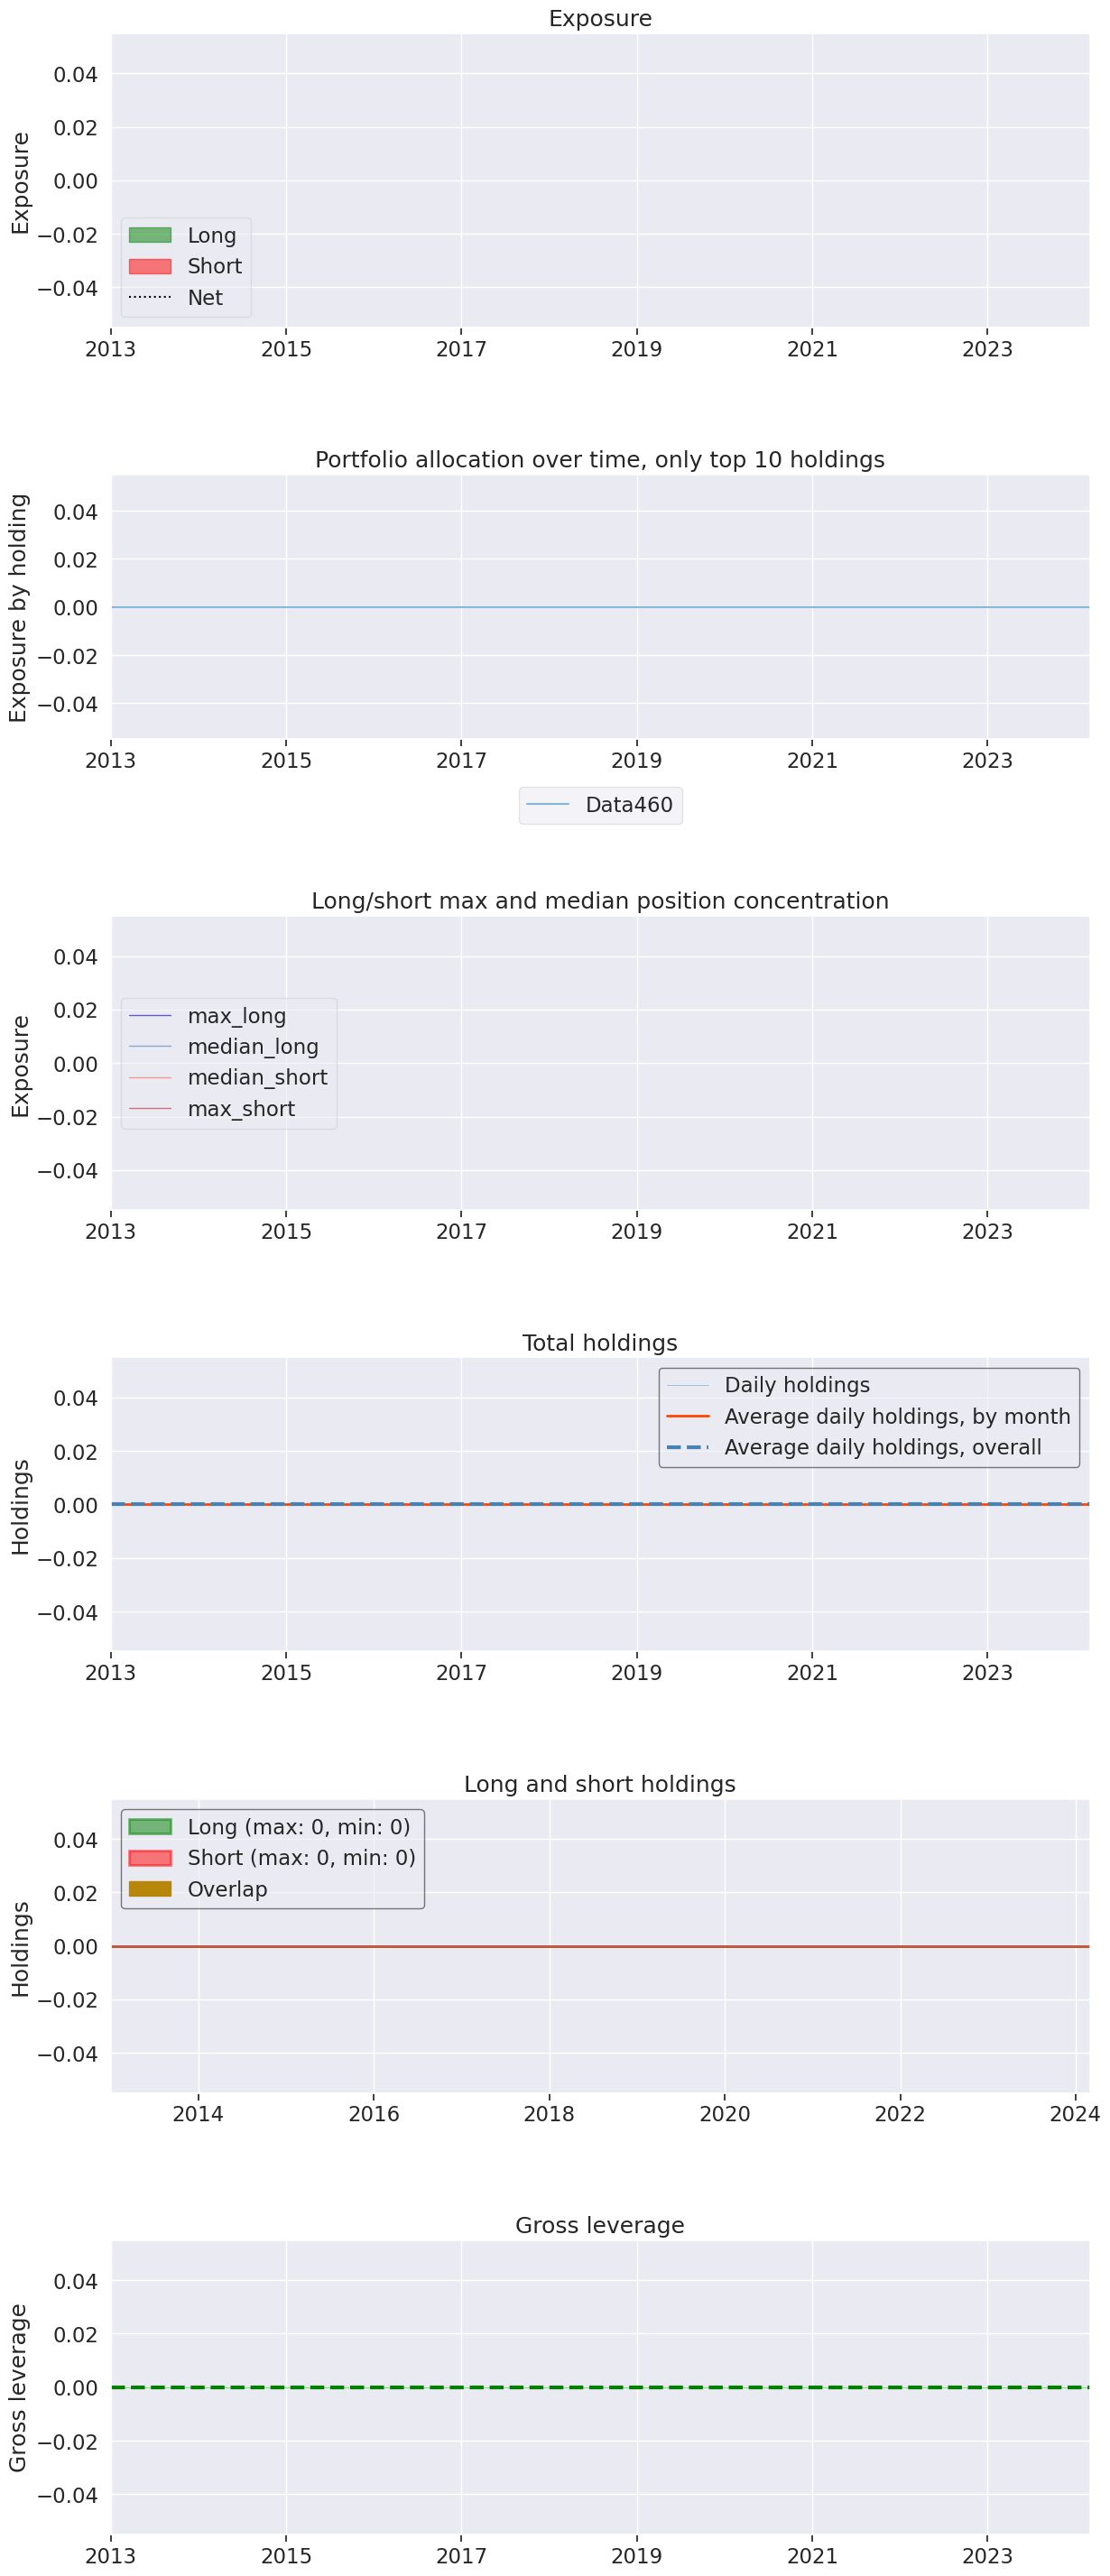

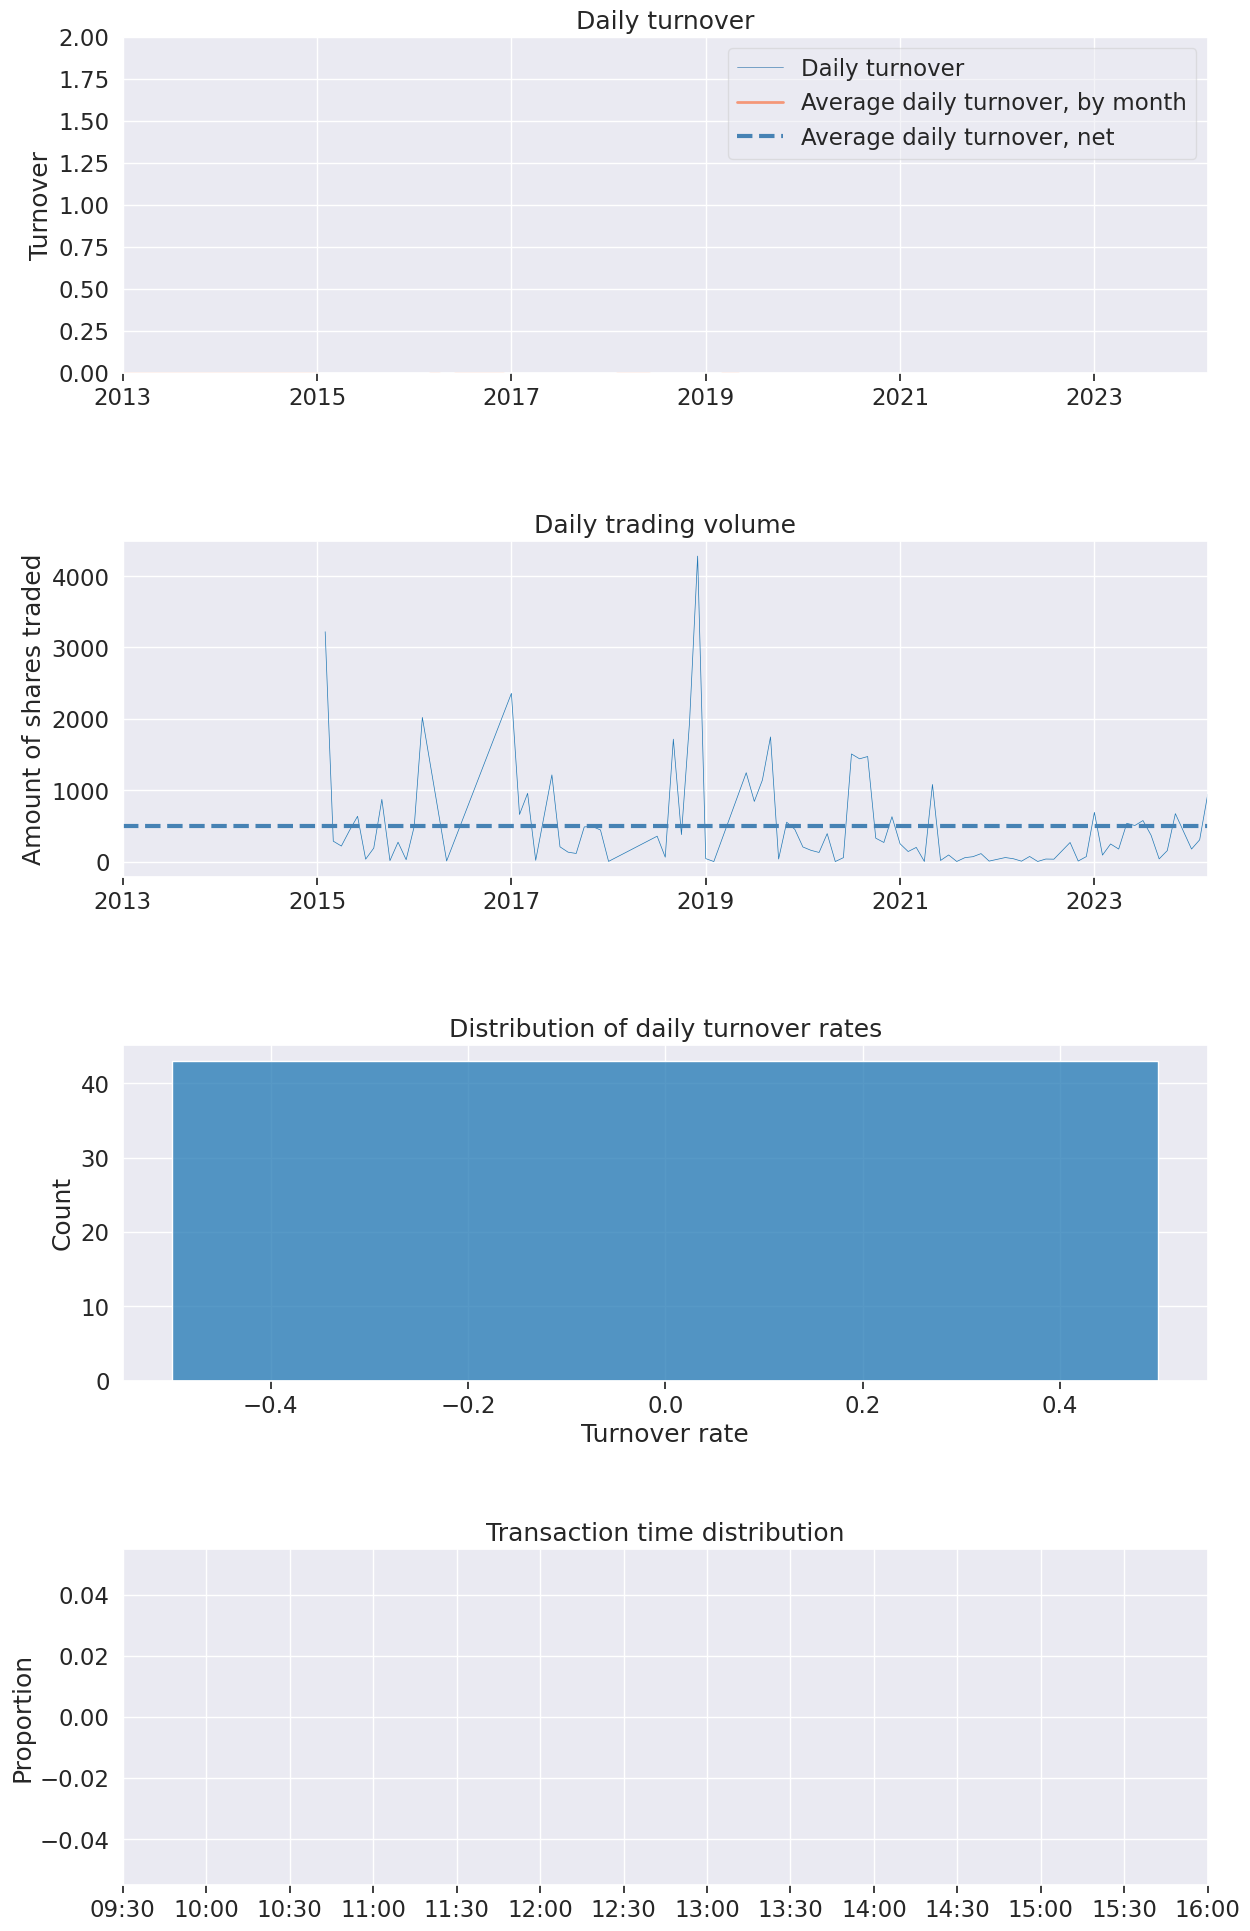

In [61]:
strat = results[0]
returns = strat.analyzers.getbyname("r").get_analysis()
print(f"Normalized return %: {returns['rnorm100']}")
pyfoliozer = strat.analyzers.getbyname("pyfolio")
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
sp500 = yf.Ticker('^GSPC').history(start="2013-01-01", interval="1mo")
sp500_returns = pd.Series(sp500.Close.pct_change().fillna(0)).reindex(returns.index, method='nearest')
create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    estimate_intraday=False,
    benchmark_rets=sp500_returns
)